# What's cooking? Text classification in Tensor Flow

The task is to guess the cuisine based on cooking receipts.

Data files are provided on Kaggle https://www.kaggle.com/c/whats-cooking

The solution is based on *scikit-learn* with the *TensorFlow* backend.

In [14]:
import tensorflow as tf
import pandas as pnd
import numpy as np
import re
import nltk
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

In [15]:
sess = tf.Session()

## Data extraction

In [16]:
# path to data files
train_data_path = 'train.json'

data = pnd.read_json(train_data_path)

# have a look
data[:10]

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [17]:
y = data['cuisine']
X = data.drop(['id','cuisine'],axis=1)

In [18]:
def preprocess(X):
    X['ingredients'] = X['ingredients'].apply(lambda t: ','.join(t))
    X['ingredients'] = X['ingredients'].astype(str)
    return X

X = preprocess(X)
X[0:10]

,ingredients
0,"romaine lettuce,black olives,grape tomatoes,ga..."
1,"plain flour,ground pepper,salt,tomatoes,ground..."
2,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,"water,vegetable oil,wheat,salt"
4,"black pepper,shallots,cornflour,cayenne pepper..."
5,"plain flour,sugar,butter,eggs,fresh ginger roo..."
6,"olive oil,salt,medium shrimp,pepper,garlic,cho..."
7,"sugar,pistachio nuts,white almond bark,flour,v..."
8,"olive oil,purple onion,fresh pineapple,pork,po..."
9,"chopped tomatoes,fresh basil,garlic,extra-virg..."


## Building the bag-of-words model

In [19]:
# build a tokenizer

pattern = r'[^,]+'
pattern = re.compile(pattern)
stemmer = nltk.stem.PorterStemmer()
def tokenize(text):
    tokens = pattern.findall(text)
    return [stemmer.stem(i) for i in tokens]

print( tokenize(str( X.loc[0].ingredients )) )

['romaine lettuc', 'black ol', 'grape tomato', 'garlic', 'pepper', 'purple onion', 'season', 'garbanzo bean', 'feta cheese crumbl']


In [20]:
# build the dictionary

counts = CountVectorizer(min_df=3,tokenizer=tokenize).fit(X['ingredients'])
voc_size = len(counts.vocabulary_)
print('Vocabulary is of size {0}'.format(voc_size))

Vocabulary is of size 4159


In [21]:
# do a train-test split

X_train0, X_test0, y_train0, y_test0 = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=11)

In [22]:
# build the document-term matrix

X_train_f = counts.transform(X_train0['ingredients'])
X_test_f = counts.transform(X_test0['ingredients'])

In [23]:
# encode targets

class_name = y_train0.unique()

y_train = y_train0.apply(lambda t: (class_name==t).argmax())
y_test = y_test0.apply(lambda t: (class_name==t).argmax())

## Training the model in TensforFlow

In [24]:
# build the TensorFlow model

n_classes = y.unique().shape[0]
n_features = voc_size

tmp = np.array( pnd.crosstab(y_train,1))
tmp = np.ones(n_classes).reshape(-1,1) + 0.0*(tmp < np.median(tmp))
w_class = tf.Variable(tmp.reshape(-1,1),dtype=np.float32,name='class_weights',trainable=False) 

global_step=tf.Variable(0, trainable=False)
r_learn = tf.Variable(0.5, trainable=False)
rate = tf.train.natural_exp_decay(r_learn, global_step, 1000 ,0.01)

# data and target placeholders (the first dimension understood as the batch size, left empty!)
X1 = tf.placeholder(shape=[None,n_features], dtype=np.float32) # dim = [batch_size,n_features]
y1 = tf.placeholder(shape=[None], dtype=tf.int32)  # dim = [batch_size]

# model coefficients
w = tf.Variable(tf.ones([n_features,n_classes]), name='weights')
b = tf.Variable(tf.zeros([1,n_classes]), name='bias')

# model predictions and loss
logits = tf.matmul(X1,w) + b # dim = [batch_size,n_classes]
labels = tf.one_hot(y1,n_classes) # dim = [batch_size,n_classes]
weights = tf.reduce_sum( tf.matmul(labels, w_class), 1 ) # dim = [batch_size]
#weights = tf.reduce_sum( tf.multiply(4, tf.cast(tf.equal(labels, 3), tf.int32)) + 1, 1)
entropy = tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = labels, weights = weights)
loss = tf.reduce_mean(entropy)

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate).minimize(loss, global_step=global_step)

# initialize
sess.run(tf.global_variables_initializer())

Training...


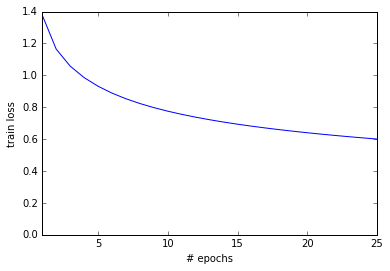

In [25]:
# train the logistic regression in batches
print('Training...')

def train(mini_batch_size=100,rate=1,n_epochs=25):
    # note: this keeps the memory usage low, by unziping the sparse feature matrix in batches
    n_samples = X_train_f.shape[0]
    n_batch = int( n_samples / mini_batch_size )
    loss_history = np.empty(shape=[1],dtype=np.float32)
    # set the learning rate
    sess.run(r_learn.assign(rate))
    # start learning
    for _ in range(n_epochs):
        for i in range(n_batch): 
            i_batch = i*mini_batch_size
            X_b = X_train_f[ i*mini_batch_size:(i+1)*mini_batch_size ]
            y_b = y_train[ i*mini_batch_size:(i+1)*mini_batch_size ]
            _, train_loss = sess.run([optimizer,loss],feed_dict={X1:X_b.todense(),y1:y_b})
        loss_history = np.append(loss_history, train_loss )
    return loss_history
        
# plot the training curve

def plot_training(n_epochs=25):
    plt.plot(loss_history)
    plt.xlim([1,n_epochs])
    plt.xlabel('# epochs')
    plt.ylabel('train loss')
    plt.show()
    
loss_history = train(rate=1,n_epochs=50)
plot_training()

In [26]:
# test the model on the hold out set
print('Testing...')

def preds(mini_batch_size=1000):
    # note: this keeps the memory usage low, by unziping the sparse feature matrix in batches
    total_score = 0
    n_samples = X_test_f.shape[0]
    n_batch = math.ceil( n_samples / mini_batch_size )
    preds = []
    for i in range(n_batch): 
        i_batch = i*mini_batch_size
        X_b = X_test_f[ i*mini_batch_size:min( (i+1)*mini_batch_size,n_samples) ]
        y_b = y_test[ i*mini_batch_size:min( (i+1)*mini_batch_size,n_samples ) ]
        _, logits_batch = sess.run([loss, logits], feed_dict={X1:X_b.todense(),y1:y_b})
        odds = tf.nn.softmax(logits_batch)
        heaviest = sess.run(tf.argmax( odds, 1))
        preds.append(heaviest)
    return preds

y_pred = np.concatenate( preds() )
print('F1-score (micro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='macro')))

Testing...
F1-score (micro-averaged)=0.7736528953322719
F1-score (macro-averaged)=0.6905714599408811


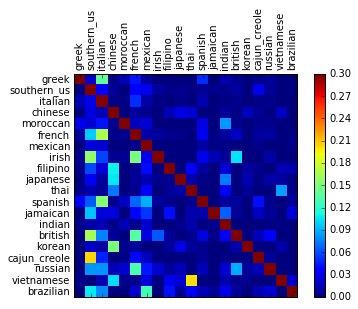

In [27]:
def report_confusion():
    tmp = np.float32( metrics.confusion_matrix(y_test, y_pred)) 
    for i in range(tmp.shape[0]):
        t = tmp[i].sum()
        tmp[i] = tmp[i]/t

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(tmp, vmin=0.0, vmax=0.3)
    fig.colorbar(cax)
    ticks = np.arange(0,n_classes,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_name, rotation=90)
    ax.set_yticklabels(class_name)
    plt.show()
    
report_confusion()

## Handling imbalanced data - class weights

By adding weights to less common classes we can trade errors, which otherwise concentrate on majority classes.

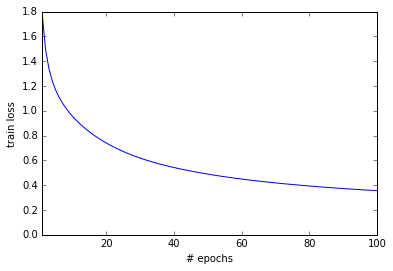

F1-score (micro-averaged)=0.7583172714321629
F1-score (macro-averaged)=0.6745789920633609


In [28]:
sess.run(tf.global_variables_initializer())

# modify the weights
tmp = np.array( pnd.crosstab(y_train,1))
tmp = np.ones(n_classes).reshape(-1,1) + 1*(tmp < np.mean(tmp))
sess.run(w_class.assign( tmp.reshape(-1,1)))

loss_history = train(n_epochs=100, rate=1.5)
plot_training(n_epochs=100)

y_pred = np.concatenate( preds() )
print('F1-score (micro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='macro')))

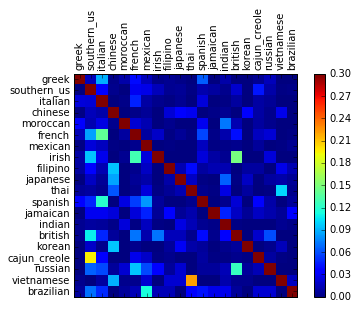

In [29]:
report_confusion()